# DRTED: Tutorial for using RNNs on EHR data for predicting severity of illness of patients in the PICU.

This tutorial illustrates how to process Electronic Health Records (EHR) data and leverage state-of-the-art deep learning techniques (RNN) to predict severity of illness in patients in a Pediatric ICU (PICU).

We will start from a pre-curated dataset, construct the deep learning model, and evaluate our model by comparing it with current baseline algorithms used in the PICU: pim2 and prism3.

### 1. Setup
* Set up python environment

In [4]:
# general imports
import numpy as np               # for numerical manipulations
import pandas as pd              # for dataframe manipulations
import os                        # convenient pathing
import matplotlib.pyplot as plt  # for plotting
import keras                     # for training RNN

# display plots in notebook
%matplotlib inline

Using Theano backend.


* Get the data

In [5]:
# set up user paths
data_dir = './data'
#data_dir = '/mnt/Swell/Data/DRTED/DRTEDv3/patientSequences/DS_3X_sequences_NVIDIA_full'  # temporary

# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

### 2. Load and Preprocess Data

EHR is a database containing medical treatments and histories of patients collected in the hospital. The EHR data used here spans 10 years worth of patients in the PICU at Children's Hospital Los Angeles, curated by the virtual PICU (vPICU) team. 

<img style="float: right;" src="images/ehr.svg" width="450" height="300">
The data is an irregular time series of measurements taken over the course of a patient's stay in the ICU. Time between measurements can vary from minutes to hours. A simplified diagram of the data can be seen on the right. Measurements include:

* **Statics** *(e.g. gender, age, weight)*
* **Vitals** *(e.g. heart rate, respiratory rate)*
* **Labs** *(e.g. glucose, creatinine)*
* **Interventions** *(e.g. intubation, O2)*
* **Drugs** *(e.g. dopamine, epinephrine)*

For a complete list, see [ehr_features.csv](ehr_features.csv)

One thing to note is that in addition to the non-uniform sampling, not all measurements were taken for all patients.

* Load databases

In [8]:
# For this convenience, the data was stored using Panda's HDF format.
X_train, y_train = pd.read_hdf(x_train_path), pd.read_hdf(y_train_path)
X_valid, y_valid = pd.read_hdf(x_valid_path), pd.read_hdf(y_valid_path)

In [9]:
# The data is a multi-index dataframe, 
#    with level 0 as the patient encounter identifier 
#    and level 1 the time of each measurement (in units of hours since first measurement)

# print the first two patient's x & y data
patients = list(X_train.index.levels[0][:2])
example_columns = ['Heart rate (bpm)', 'PulseOximetry']

# build fancy print function to print x & y dataframes side by side.
def print_examples():
    pd.set_option("display.max_rows", 20)
    x_string = X_train.loc[patients, example_columns].__str__().split('\n')
    y_string = y_train.loc[patients].__str__().split('\n')
    ret = ["X_train" + ' ' * len(x_string[0]) + "y_train"]
    for i in range(len(x_string) - 2):
        ret.append(x_string[i] + '   |   ' + y_string[i])
    print('\n'.join(ret))

print_examples()

X_train                                                               y_train
                                Heart rate (bpm)  PulseOximetry   |                                   mortalityResponse
b'encounterID' b'absoluteTime'                                    |   b'encounterID' b'absoluteTime'                   
8              0.000000                    107.0          100.0   |   8              0.000000                         1
               0.250000                     98.0          100.0   |                  0.250000                         1
               0.500000                      NaN            NaN   |                  0.500000                         1
               0.583333                      NaN            NaN   |                  0.583333                         1
               0.750000                    103.0          100.0   |                  0.750000                         1
               1.383333                      NaN            NaN   |               

* Preprocess data

For each feature, center the data around the origin (mean subtraction) and normalize (apply unit variance). This puts each measurement on the same scale to be equally important to the learning algorithm. Experimentally, this has shown to lead to more stable initializations & training of the algorithm.

In [11]:
# For convenience, each feature statistics was calculated and stored in `data/ehr_features.csv`
feature_stats = pd.read_csv(os.path.join(data_dir, 'ehr_features.csv'), index_col=0)
feature_stats = feature_stats[feature_stats['type'].isin(['Interventions', 'Labs', 'Vitals'])]
for feature_name, vals in feature_stats.iterrows():
    # training data
    X_train[feature_name] = X_train[feature_name] - vals['mean']
    X_train[feature_name] = X_train[feature_name] / (vals['std'] + 1e-12)
    
    # validation data
    X_valid[feature_name] = X_valid[feature_name] - vals['mean']
    X_valid[feature_name] = X_valid[feature_name] / (vals['std'] + 1e-12)
    
# print the two patients data again, now with zero-mean unit variance
print_examples()

X_train                                                               y_train
                                Heart rate (bpm)  PulseOximetry   |                                   mortalityResponse
b'encounterID' b'absoluteTime'                                    |   b'encounterID' b'absoluteTime'                   
8              0.000000                -0.429630       0.805317   |   8              0.000000                         1
               0.250000                -0.986894       0.805317   |                  0.250000                         1
               0.500000                      NaN            NaN   |                  0.500000                         1
               0.583333                      NaN            NaN   |                  0.583333                         1
               0.750000                -0.677303       0.805317   |                  0.750000                         1
               1.383333                      NaN            NaN   |               

* Impute missing data

Imputing missing data is a very active area of research. There is currently no standard practice -- especially for applications of time series and deep learning models. For this tutorial, we will simply forward fill existing measurements for each patient, and fill any feature with no measurement to 0. This is illustrated in the figure below.

<img src="images/imputation_diagram.svg" width="800" height="200">

In [12]:
# Use panda's great dataframe functions to forward fill each patient's measurements and fill any non-measured with 0.
# on the training data. This is only done for vitals and labs. Computation will take ~30 seconds.
ffill_cols = feature_stats[feature_stats['type'].isin(['Vitals', 'Labs'])].index
X_train[ffill_cols] = X_train.groupby(level=0)[ffill_cols].ffill()
X_train.fillna(value=0, inplace=True)

# on the validation data
X_valid[ffill_cols] = X_valid.groupby(level=0)[ffill_cols].ffill()
X_valid.fillna(value=0, inplace=True)

# print the two patients data again, now with imputations
print_examples()

X_train                                                               y_train
                                Heart rate (bpm)  PulseOximetry   |                                   mortalityResponse
b'encounterID' b'absoluteTime'                                    |   b'encounterID' b'absoluteTime'                   
8              0.000000                -0.429630       0.805317   |   8              0.000000                         1
               0.250000                -0.986894       0.805317   |                  0.250000                         1
               0.500000                -0.986894       0.805317   |                  0.500000                         1
               0.583333                -0.986894       0.805317   |                  0.583333                         1
               0.750000                -0.677303       0.805317   |                  0.750000                         1
               1.383333                -0.677303       0.805317   |               

* Prepare data into minibatches for training the RNN (Computation should take ~60 seconds
)

In [7]:
from keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a unique list of training patients
train_patients = np.array(X_train.index.levels[0])

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in train_patients]
X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

y_train = [y_train.loc[patient].values for patient in train_patients]
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data
valid_patients = np.array(X_valid.index.levels[0])
X_valid = [X_valid.loc[patient].values for patient in valid_patients]
X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

y_valid = [y_valid.loc[patient].values for patient in valid_patients]
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

In [8]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


### 3. Train Recurrent Neural Network (using keras)

We'll construct an RNN in order to ingest the data and make a prediction at each timestep of the patient's probability of survival. The image below shows an abstract representation of the model.

<img src="images/drted_rnn.svg" width="1000" height="400">

We will be using a many-to-many prediction scheme. At each time step the measurements recorded will be used as input and a probability of survival prediction will be generated. It is important to note that this enables a real time monitor of the patient's probability of survival and insight into the patient's trajectory.

For more information on RNNs we recommend [Andrej Kaparthy's Blog on The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [Christopher Olah's tutorial for Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

* Build model using Keras Functional API (version > 1.0)

In [15]:
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model
from keras.optimizers import RMSprop

# minibatch size
batch_size = 128

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout_W': 0.25, 'dropout_U': 0.1, 'return_sequences': True, 'consume_less': 'gpu'}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)
lstm2 = LSTM(256, name='lstm2', **lstm_kwargs)(lstm1)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm2)
model = Model(input=x, output=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, 265)     0                                            
____________________________________________________________________________________________________
input_masked (Masking)           (None, None, 265)     0           input[0][0]                      
____________________________________________________________________________________________________
lstm1 (LSTM)                     (None, None, 128)     201728      input_masked[0][0]               
____________________________________________________________________________________________________
lstm2 (LSTM)                     (None, None, 256)     394240      lstm1[0][0]                      
___________________________________________________________________________________________

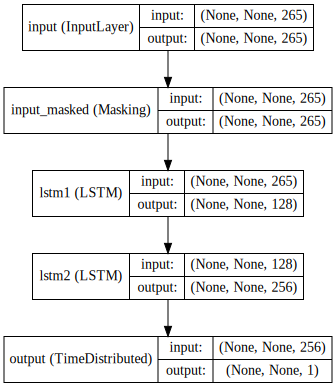

In [16]:
# visualize model. Note: Requires pydot & graphviz. Uncomment block if want to view model diagram
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

* Train model

In [17]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20, verbose=1)

Epoch 1/20
5000/5000 [==============================] - 20s - loss: 0.2958    
Epoch 2/20
5000/5000 [==============================] - 20s - loss: 0.2423    
Epoch 3/20
5000/5000 [==============================] - 20s - loss: 0.2191    
Epoch 4/20
5000/5000 [==============================] - 20s - loss: 0.2103    
Epoch 5/20
5000/5000 [==============================] - 20s - loss: 0.2004    
Epoch 6/20
5000/5000 [==============================] - 20s - loss: 0.1946    
Epoch 7/20
5000/5000 [==============================] - 20s - loss: 0.1950    
Epoch 8/20
5000/5000 [==============================] - 20s - loss: 0.1847    
Epoch 9/20
5000/5000 [==============================] - 20s - loss: 0.1739    
Epoch 10/20
5000/5000 [==============================] - 20s - loss: 0.1744    
Epoch 11/20
5000/5000 [==============================] - 20s - loss: 0.1681    
Epoch 12/20
5000/5000 [==============================] - 20s - loss: 0.1612    
Epoch 13/20
5000/5000 [==========================

### 4. Evaluate Model & Compare with baselines

* Evaluate performance on the hold out set

In [18]:
from sklearn.metrics import roc_curve, auc

# generate RNN results on holdout validation set
preds = model.predict(X_valid)

# compute ROC curve and AUC
rnn_roc = roc_curve(y_valid[:, 0, :].squeeze(), preds[:, -1, :].squeeze())
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

* Compare against baselines: PRISM3 and PIM2

In [19]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# let's load the scores, then compute the ROC curves and AUC
baseline_scores = pd.read_csv(os.path.join(data_dir, 'pim2prism3.csv'))

# prism3
prism3_roc = roc_curve(baseline_scores['mortalityResponse'], -baseline_scores['PRISM3'])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

# pim2
pim2_roc = roc_curve(baseline_scores['mortalityResponse'], -baseline_scores['PIM2'])
pim2_auc = auc(pim2_roc[0], pim2_roc[1])

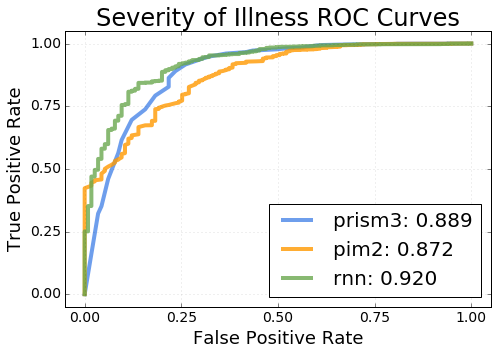

In [20]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

### 5. Conclusions

RNNs provide a method to quickly extract clinically significant information and insights from available EHR data.

To lessen computational burden, the amount of data, model complexity, number of features, and number of epochs have been reduced in this tutorial.  The examples below display the performance of a fully trained RNN on a larger dataset.  They also show the performance of PIM2 and PRISM3, two standard scoring systems,  as well as the performance of a logistic regression model and a multi-layer perceptron (MLP).  

The temporally dynamic nature of the RNN enables it to extract more information from the underlying EHR than an MLP.  The MLP's complexity is similar to the RNN's, but the former is limited to instantaneous information.

<img src="images/RNN_performance.svg" width="500" height="500">

Below shows the temporal trajectory of the fully trained RNN's probability of survival predictions. The capability to provide a prediction at any timestep of interest provides a valuable feedback to a clinician trying to asses the impact of treatment decisions.   

<img src="images/MortalityThroughTime.svg" width="500" height="500">
